In [2]:
!pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import cv2 
import os
import random
import numpy as np
from matplotlib import pyplot as plt
#import standard dependencies

In [4]:
# import tensorflow dependencies - functional api
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [5]:
# set gpu growth 
# avoid out of memery errors by setting gpu memory consumption growth 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [6]:
#setup paths
POS_PATH = os.path.join('data2','positive')
NEG_PATH = os.path.join('data2','negative')
ANC_PATH = os.path.join('data2','anchor')

In [7]:
POS_PATH

'data2\\positive'

In [7]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [8]:
import os
os.getcwd()

'C:\\Users\\TANU'

In [9]:
!pip install ipynbname

Defaulting to user installation because normal site-packages is not writeable


In [10]:
import ipynbname
print(ipynbname.path())

C:\Users\TANU\siamese network.ipynb


In [11]:
#import uuid lib to generate unique image names
import uuid

In [12]:
'{}.jpg'.format(uuid.uuid1())

'4f2f87d0-5174-11f0-8720-38d57a311a04.jpg'

In [13]:
#establish connection to web cam
cap = cv2.VideoCapture(0)
#Starts a loop that continues as long as the webcam is successfully opened
while cap.isOpened():
    # Reads a frame from the webcam. ret is a boolean indicating if the read was successful, and frame contains the image data.
    ret,frame = cap.read()
    #cut down frame to 250 x 250 pixels
    frame = frame[120:120+250,200:200+250,:]
    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create a unique file path
        imgname = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)
        
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #create a unique file path
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)
        
    #show image back to screen
    cv2.imshow('Image Collection',frame)
    #breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
#release the webcam
cap.release()
#close the image show frame
cv2.destroyAllWindows()

In [14]:
ANC_PATH + '\\*.jpg'

'data2\\anchor\\*.jpg'

In [15]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [16]:
import os
import uuid

In [27]:
img_path = os.path.join(ANC_PATH, '0a77a04b-3465-11f0-94b9-38d57a311a04.jpg')  # Add correct extension
img = cv2.imread(img_path)

if img is None:
    raise ValueError(f"Image not found at path: {img_path}")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Optional, if TensorFlow expects RGB

augmented_images = data_aug(img)
for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, f"{uuid.uuid1()}.jpg"), image.numpy())

In [28]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [29]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [17]:
anchor = tf.data.Dataset.list_files(rf"{ANC_PATH}\*.jpg").take(1500)
positive = tf.data.Dataset.list_files(rf"{POS_PATH}\*.jpg").take(1500)
negative = tf.data.Dataset.list_files(rf"{NEG_PATH}\*.jpg").take(1500)

In [18]:
def preprocess(file_path):
    # read image from file path into raw byte format.
    byte_img = tf.io.read_file(file_path)
    # Decodes the JPEG image into a TensorFlow tensor
    img = tf.io.decode_jpeg(byte_img)
    #preprocessing steps  = resizing the image ot be 100x100x3 
    img = tf.image.resize(img,(100,100))
    img = img / 255.0
    # Normalizes pixel values from [0, 255] to [0.0, 1.0].
    return img

In [19]:
def add_adversarial_noise(img, epsilon=None, min_epsilon=0.01, max_epsilon=0.1):
    if epsilon is None:
        epsilon = random.uniform(min_epsilon, max_epsilon)
    noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=epsilon)
    adv_img = img + noise
    adv_img = tf.clip_by_value(adv_img, 0.0, 1.0)
    return adv_img

In [20]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)
# (combines) the positive and negative datasets into a single dataset called data.

In [21]:
samples = data.as_numpy_iterator()

In [22]:
example = samples.next()

In [23]:
example

(b'data2\\anchor\\ed90f034-4ceb-11f0-a307-38d57a311a04.jpg',
 b'data2\\positive\\d71ffbf6-4ceb-11f0-ade0-38d57a311a04.jpg',
 1.0)

In [24]:
# Create it once, globally
rotate_layer = tf.keras.layers.RandomRotation(
    factor=(-30 / 180.0, 30 / 180.0)
)

def add_attack_angle(img):
    # Ensure image is rank 4: (1, H, W, C)
    if len(img.shape) == 3:
        img = tf.expand_dims(img, axis=0)
    elif len(img.shape) > 4:
        raise ValueError(f"Unexpected shape {img.shape} passed to add_attack_angle")

    rotated = rotate_layer(img, training=True)[0]  # Remove batch after rotation
    return rotated

In [25]:
def add_field_noise(img):
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    return img

def preprocess_twin(input_img, validation_img, label):
    img1 = preprocess(input_img)
    img2 = preprocess(validation_img)

    img1 = add_attack_angle(img1)
    img2 = add_attack_angle(img2)

    # With 50% probability, add adversarial noise
    if random.random() < 0.5:
        img1 = add_adversarial_noise(img1)
    if random.random() < 0.5:
        img2 = add_adversarial_noise(img2)

    img1 = add_field_noise(img1)
    img2 = add_field_noise(img2)
    return (img1, img2, label)


In [26]:
def evaluate_model_at_different_severities(model, test_data, severity_levels=[0.05, 0.1, 0.2, 0.3, 0.5]):
    """Evaluate model performance across different adversarial severity levels"""
    results = {}
    
    for severity in severity_levels:
        print(f"Testing severity level: {severity}")
        correct_predictions = 0
        total_predictions = 0
        
        for batch in test_data.take(20):  # Test on subset
            img1, img2, label = batch
            
            # Apply adversarial noise with specific severity
            img1_adv = add_adversarial_noise(img1, epsilon=severity)
            img2_adv = add_adversarial_noise(img2, epsilon=severity)
            
            # Get model predictions (you'll need to implement this based on your model)
            # prediction = model.predict([img1_adv, img2_adv])
            # Add your prediction logic here
            
            total_predictions += 1
            # Add your accuracy calculation here
        
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        results[severity] = accuracy
        print(f"Accuracy at severity {severity}: {accuracy:.3f}")
    
    return results

# Visualize severity impact
def plot_severity_impact(results):
    severities = list(results.keys())
    accuracies = list(results.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(severities, accuracies, marker='o', linewidth=2, markersize=8)
    plt.xlabel('Adversarial Noise Severity (ε)')
    plt.ylabel('Model Accuracy')
    plt.title('Model Performance Degradation vs Adversarial Severity')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return plt


In [27]:
res = preprocess_twin(*example)

In [28]:
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.48068815, 0.49638262, 0.40956962],
         [0.3199307 , 0.4202181 , 0.469047  ],
         [0.3761533 , 0.3286346 , 0.30890936],
         ...,
         [0.53926283, 0.586497  , 0.6673271 ],
         [0.63676983, 0.7130062 , 0.5949324 ],
         [0.73869306, 0.9160635 , 0.6323987 ]],
 
        [[0.63402987, 0.63439566, 0.592579  ],
         [0.42048556, 0.57773495, 0.5569101 ],
         [0.38511166, 0.35275418, 0.45656022],
         ...,
         [0.5943091 , 0.5044566 , 0.46736044],
         [0.6040941 , 0.62570965, 0.58497316],
         [0.9299525 , 0.8964369 , 0.84358686]],
 
        [[0.48321152, 0.6234503 , 0.64057314],
         [0.59805137, 0.8257554 , 0.56633806],
         [0.58401686, 0.54090637, 0.460124  ],
         ...,
         [0.37918115, 0.4909145 , 0.4823201 ],
         [0.6376774 , 0.55209297, 0.5943405 ],
         [0.70168114, 0.7375917 , 0.5541679 ]],
 
        ...,
 
        [[0.4092746 , 0.45979482

In [29]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=2000)

In [30]:
samples = data.as_numpy_iterator()

In [31]:
samples

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x000001E310955250>)

In [32]:
len(samples.next())

3

In [33]:
samp = samples.next()

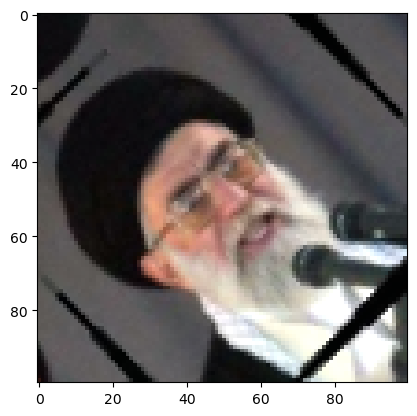

In [34]:
plt.imshow(np.clip(samp[1], 0, 1))


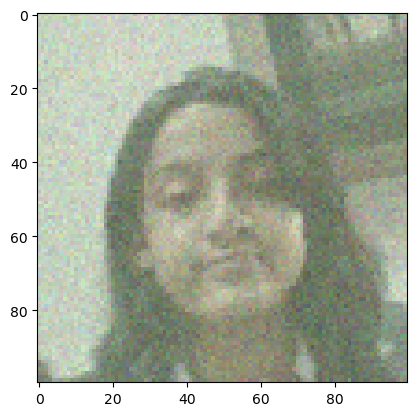

In [35]:
plt.imshow(np.clip(samp[0], 0, 1))


In [36]:
samp[2]

0.0

In [37]:
round(len(data)*.7)

2100

In [38]:
train_data = data.take(round(len(data)*.7))
# Selects the first 70% of the dataset for training by taking a rounded number of samples from data.
train_data = train_data.batch(16)
# Groups the training data into batches of 16 samples each, which is useful for efficient training.
train_data = train_data.prefetch(8)
# Prefetches 8 batches in the background while the model is training, improving input pipeline performance.

In [39]:
train_samples = train_data.as_numpy_iterator()

In [40]:
train_sample = train_samples.next()

In [41]:
len(train_sample)

3

In [42]:
#testing partition
test_data = data.skip(round(len(data)*.7))
# Skips the first 70% of the dataset to use the remaining 30% for testing.
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
# Groups the test data into batches of 16 samples each.
test_data = test_data.prefetch(8)

In [43]:
inp = Input(shape=(100,100,3),name='input_image')
# Defines a Keras Input layer for the model, expecting
# images of shape 100x100 pixels with 3 color channels (RGB), and names the input 'input_image'.

In [44]:
inp

<KerasTensor shape=(None, 100, 100, 3), dtype=float32, sparse=False, ragged=False, name=input_image>

In [45]:
#build embedding layer
#model engineering
#build embedding layer
def make_embedding():
    inp = Input(shape=(100,100,3),name='input_image')
    # Creates a Keras Input layer expecting images of shape 100x100 pixels with 3 color channels (RGB). 
    #first block
    c1 = Conv2D(64,(10,10),activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding = 'same')(c1)
    # MaxPooling2D(64, (2,2)): Reduces spatial dimensions by a factor of 2

    #second block
    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    #  Learns finer features using smaller receptive fields than the first block.
    # Applies a convolutional layer with 128 filters of size 7x7 and ReLU
    # activation to the output of the first pooling layer.
    m2 = MaxPooling2D(64,(2,2),padding = 'same')(c2)
    # Applies max pooling (pool size 2x2, 'same' padding) to the output of the second convolution.
    
    #third block
    c3 = Conv2D(128,(4,4),activation='relu')(m2)
    # Applies a convolutional layer with 128 filters of size 4x4 and ReLU activation 
    # to the output of the second pooling layer.
    m3 = MaxPooling2D(64,(2,2),padding = 'same')(c3)
    # Applies max pooling (pool size 2x2, 'same' padding) to the output of the third convolution.

    #final
    c4 = Conv2D(256,(4,4),activation='relu')(m3)
    # Deep, rich feature extraction.
    f1 = Flatten()(c4)
    # Converts the feature maps into a 1D vector.
    d1 = Dense(4096,activation='sigmoid')(f1)
    # Applies a dense (fully connected) layer with 4096 units and sigmoid activation 
    # to the flattened vector. This produces the final embedding.
    
    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [46]:
 embedding = make_embedding()

In [47]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [49]:
l1 = L1Dist()

In [50]:
l1(anchor_embedding,validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [53]:
input_image = Input(name='input_img',shape=(100,100,3))
validation_image = Input(name='validation_img',shape=(100,100,3))

In [54]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [55]:
embedding(input_image)

[<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, ragged=False, name=keras_tensor_11>]

In [56]:
siamese_layer = L1Dist()
# Creates an instance of your custom L1 distance layer, which computes the absolute difference between two embeddings.

In [57]:
distances=siamese_layer(inp_embedding[0], val_embedding[0])

In [58]:
classifier = Dense(1,activation='sigmoid')(distances)
# Adds a dense (fully connected) layer with a single output and sigmoid activation, which outputs a probability
# (between 0 and 1) indicating whether the two images are similar (likely the same class) or not.

In [59]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_13>

In [60]:
siamese_network = Model(inputs=[input_image,validation_image],outputs=classifier,name = 'SiameseNetwork')

In [61]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
def make_siamese_model():
    input_image = Input(name='input_img', shape=(100, 100, 3))
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Get embeddings as TENSORS (not lists)
    inp_embedding = embedding(input_image)[0]
    val_embedding = embedding(validation_image)[0]

    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    
    distances = siamese_layer(inp_embedding, val_embedding)

    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [63]:
siamese_model = make_siamese_model()

In [64]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_3 (L1Dist)            │ (None, 4096)              │               0 │ embedding[3][0],           │
│                               │                           │                 │ embedding[4][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
import tensorflow as tf
import tensorflow.keras.backend as K

def contrastive_loss(y_true, y_pred, margin=1):
    y_true = tf.cast(y_true, y_pred.dtype)
    squared_pred = K.square(y_pred)
    squared_margin = K.square(K.maximum(margin - y_pred, 0))
    loss = K.mean(y_true * squared_pred + (1 - y_true) * squared_margin)
    return loss


In [66]:
#training
binary_Cross_loss = tf.losses.BinaryCrossentropy()

In [67]:
opt = tf.keras.optimizers.Adam(1e-4)

In [68]:
#establish checkpoints 
checkpoint_dir ='./training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

In [69]:
test_batch = train_data.as_numpy_iterator()

In [70]:
batch_1 = test_batch.next()

In [71]:
X = batch_1[:2]
# Extracts the first two elements of the batch (the image pairs: anchor and validation images) and stores them in X.

In [72]:
y = batch_1[2]
# Extracts the third element (the labels) and stores it in y.

In [73]:
y

array([1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.],
      dtype=float32)

In [74]:
len(batch_1)

3

In [75]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [76]:
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()

In [77]:
from tensorflow.keras.metrics import Recall, Precision

In [78]:
# build train step function 
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        #get anchor and positive/negative image 
        X = batch[:2]
        # Extracts the input image pair (anchor and positive/negative sample).
        # get label
        y = batch[2]
        # Extracts the label (1 for similar, 0 for dissimilar).
        #froward pass
        yhat = siamese_model(X,training=True)
        #calc loss
        loss = binary_cross_loss(y,yhat)

    print(loss)
    grad = tape.gradient(loss,siamese_model.trainable_variables)
    # calac updated weights and apply to siamese model
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss

In [79]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [80]:
#train the model
EPOCHS = 5

In [81]:
train(train_data,EPOCHS)


 Epoch 1/5
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/stept
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/stept
1/1 ━━━━━━━━━━━━━━━

In [85]:
#evaluate model
from tensorflow.keras.metrics import Precision, Recall

In [86]:
test_input, test_val, y_true  = test_data.as_numpy_iterator().next()

In [87]:
test_var  = test_data.as_numpy_iterator().next()

In [88]:
len(test_var)

3

In [89]:
y_hat = siamese_model.predict([test_input,test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


array([[4.3472496e-04],
       [1.9332947e-05],
       [9.9937063e-01],
       [5.9882153e-02],
       [9.8288369e-01],
       [9.8712492e-01],
       [1.6816323e-06],
       [9.9972630e-01],
       [2.3439895e-04],
       [9.9987447e-01],
       [1.6679985e-06],
       [9.9886876e-01],
       [3.4991535e-05],
       [9.9942684e-01],
       [1.5922694e-03],
       [1.7477421e-02]], dtype=float32)

In [90]:
#post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0]

In [91]:
#creating a metric object
m=Precision()
#calculating the recall value
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

In [92]:
#creating a metric object
m=Recall()
#calculating the recall value
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

In [93]:
r = Recall()
p = Precision()

for test_input , test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input,test_val])
    r.update_state(y_true,yhat)
    p.update_state(y_true,yhat)
print(r.result().numpy() , p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

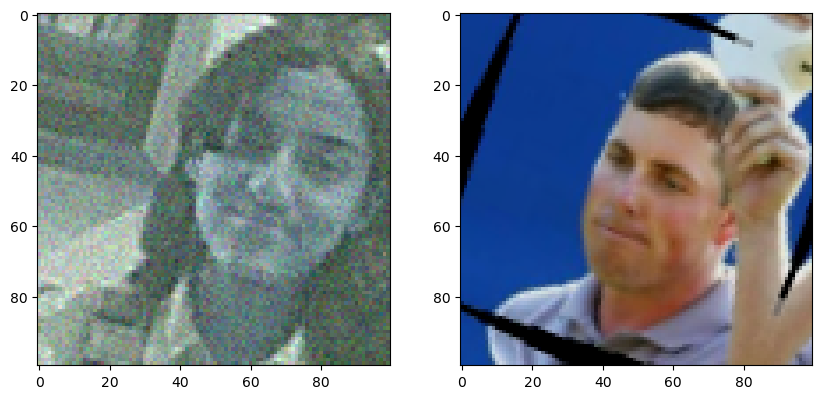

In [114]:
# visaluize results
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(np.clip(test_input[0], 0, 1))
plt.subplot(1,2,2)
plt.imshow(np.clip(test_val[0], 0, 1))
plt.show()

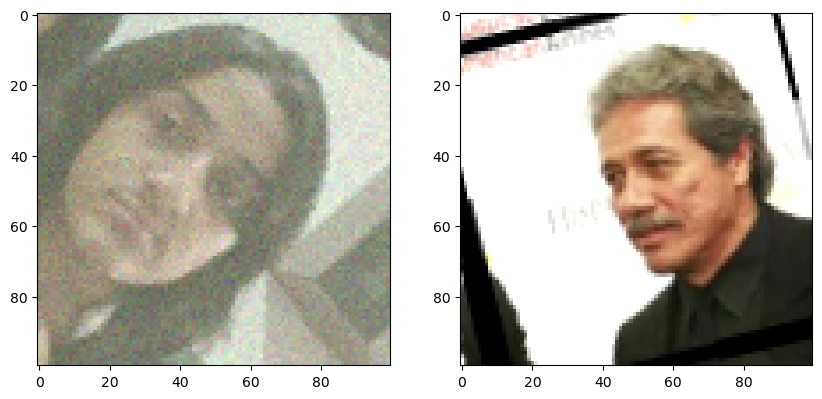

In [116]:
# visaluize results
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(np.clip(test_input[1], 0, 1))
plt.subplot(1,2,2)
plt.imshow(np.clip(test_val[1], 0, 1))
plt.show()

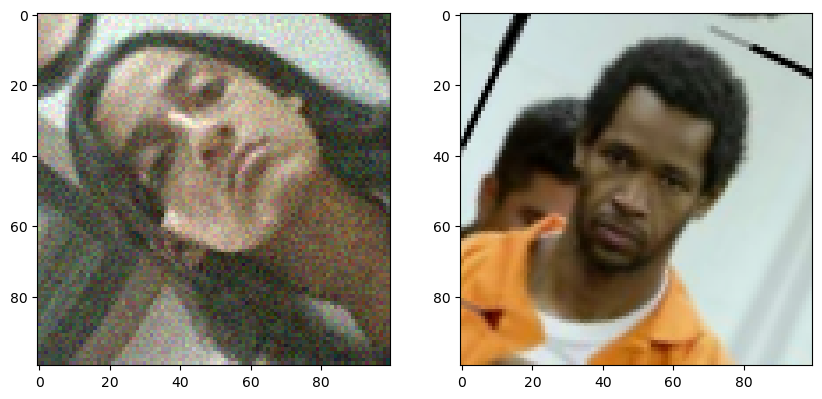

In [117]:
# visaluize results
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(np.clip(test_input[2], 0, 1))
plt.subplot(1,2,2)
plt.imshow(np.clip(test_val[2], 0, 1))
plt.show()

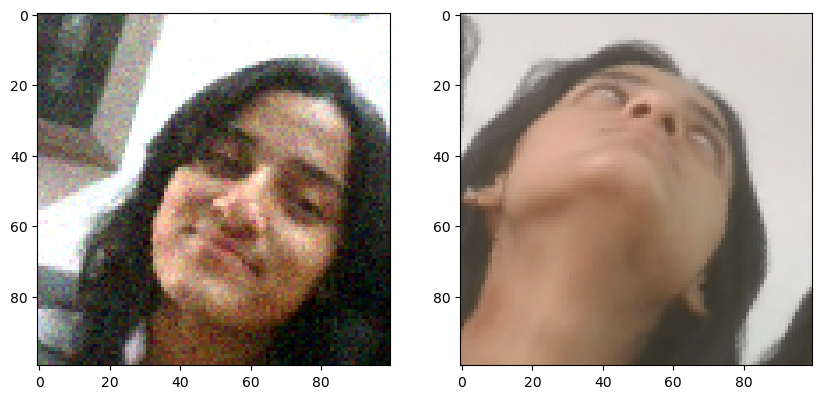

In [118]:
# visaluize results
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(np.clip(test_input[3], 0, 1))
plt.subplot(1,2,2)
plt.imshow(np.clip(test_val[3], 0, 1))
plt.show()

In [98]:
siamese_model.save('siamesemodelv9.keras')

In [99]:
L1Dist

__main__.L1Dist

In [100]:
siamese_model = tf.keras.models.load_model('siamesemodelv9.keras', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [101]:
siamese_model.load_weights

<bound method Model.load_weights of <Functional name=SiameseNetwork, built=True>>

In [102]:
siamese_model.predict([test_input, test_val])
#make predicitions with reloaded model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


array([[1.3197912e-07],
       [4.3734733e-04],
       [5.1441719e-05],
       [9.9745756e-01]], dtype=float32)

In [103]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_4 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_4[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
os.listdir(os.path.join('application_data','verification_images'))

['0215639a-4a70-11f0-8a8b-38d57a311a04.jpg',
 '049bfb3c-3465-11f0-9c3b-38d57a311a04.jpg',
 '06134c04-3465-11f0-9202-38d57a311a04.jpg',
 '067363d8-4a70-11f0-a002-38d57a311a04.jpg',
 '06b3a57a-4a70-11f0-8d73-38d57a311a04.jpg',
 '06e8c101-3465-11f0-9d82-38d57a311a04.jpg',
 '08bc3a49-4a70-11f0-a4d4-38d57a311a04.jpg',
 '0a77a04b-3465-11f0-94b9-38d57a311a04.jpg',
 '0b5d8337-4a70-11f0-b600-38d57a311a04.jpg',
 '0c50794a-4a70-11f0-877f-38d57a311a04.jpg',
 '0d2de622-4a70-11f0-8e9c-38d57a311a04.jpg',
 '0dd881fd-3465-11f0-910d-38d57a311a04.jpg',
 '103b4b8a-3465-11f0-96cc-38d57a311a04.jpg',
 '1077bbb7-4a70-11f0-b41a-38d57a311a04.jpg',
 '10bf0e62-4a70-11f0-afda-38d57a311a04.jpg',
 '10faf3a3-3465-11f0-8395-38d57a311a04.jpg',
 '118da959-4a70-11f0-ac92-38d57a311a04.jpg',
 '1225cbfd-3465-11f0-a1f5-38d57a311a04.jpg',
 '138c474c-3465-11f0-bb8d-38d57a311a04.jpg',
 '1461f071-3465-11f0-b9f3-38d57a311a04.jpg',
 '158ca8d5-3465-11f0-aa4d-38d57a311a04.jpg',
 '158eb54f-4a70-11f0-9d49-38d57a311a04.jpg',
 '15d73aa7

In [105]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\0215639a-4a70-11f0-8a8b-38d57a311a04.jpg
application_data\verification_images\049bfb3c-3465-11f0-9c3b-38d57a311a04.jpg
application_data\verification_images\06134c04-3465-11f0-9202-38d57a311a04.jpg
application_data\verification_images\067363d8-4a70-11f0-a002-38d57a311a04.jpg
application_data\verification_images\06b3a57a-4a70-11f0-8d73-38d57a311a04.jpg
application_data\verification_images\06e8c101-3465-11f0-9d82-38d57a311a04.jpg
application_data\verification_images\08bc3a49-4a70-11f0-a4d4-38d57a311a04.jpg
application_data\verification_images\0a77a04b-3465-11f0-94b9-38d57a311a04.jpg
application_data\verification_images\0b5d8337-4a70-11f0-b600-38d57a311a04.jpg
application_data\verification_images\0c50794a-4a70-11f0-877f-38d57a311a04.jpg
application_data\verification_images\0d2de622-4a70-11f0-8e9c-38d57a311a04.jpg
application_data\verification_images\0dd881fd-3465-11f0-910d-38d57a311a04.jpg
application_data\verification_images\103b4b8a-3465-11f0-96cc-38d

In [106]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [107]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━

In [109]:
results

[array([[0.98779]], dtype=float32),
 array([[0.21899675]], dtype=float32),
 array([[0.5542475]], dtype=float32),
 array([[0.95424646]], dtype=float32),
 array([[0.97372246]], dtype=float32),
 array([[0.3620273]], dtype=float32),
 array([[0.98907554]], dtype=float32),
 array([[0.12912655]], dtype=float32),
 array([[0.918013]], dtype=float32),
 array([[0.9965861]], dtype=float32),
 array([[0.9935182]], dtype=float32),
 array([[0.17613347]], dtype=float32),
 array([[0.6350075]], dtype=float32),
 array([[0.9940472]], dtype=float32),
 array([[0.99741584]], dtype=float32),
 array([[0.15368871]], dtype=float32),
 array([[0.79654586]], dtype=float32),
 array([[0.2841377]], dtype=float32),
 array([[0.5471101]], dtype=float32),
 array([[0.48315194]], dtype=float32),
 array([[0.38227963]], dtype=float32),
 array([[0.9974623]], dtype=float32),
 array([[0.3280992]], dtype=float32),
 array([[0.99588656]], dtype=float32),
 array([[0.828458]], dtype=float32),
 array([[0.9925915]], dtype=float32),
 arr

In [110]:
def evaluate_model_under_attack(model, dataset, epsilons=[0.01, 0.05, 0.1]):
    results = {}
    for eps in epsilons:
        acc = []
        for img1, img2, label in dataset.take(10):  # Can increase if needed
            img1_adv = add_adversarial_noise(img1, epsilon=eps)
            img2_adv = add_adversarial_noise(img2, epsilon=eps)

            # No expand_dims needed — already batched
            pred = model.predict([img1_adv, img2_adv], verbose=0)

            # Threshold predictions
            pred_labels = (pred > 0.5).astype(int).squeeze()

            # Handle batch of labels
            true_labels = tf.cast(label, tf.int32).numpy()
            correct = (pred_labels == true_labels).sum()
            acc.append(correct / len(true_labels))

        results[eps] = sum(acc) / len(acc)
    return results


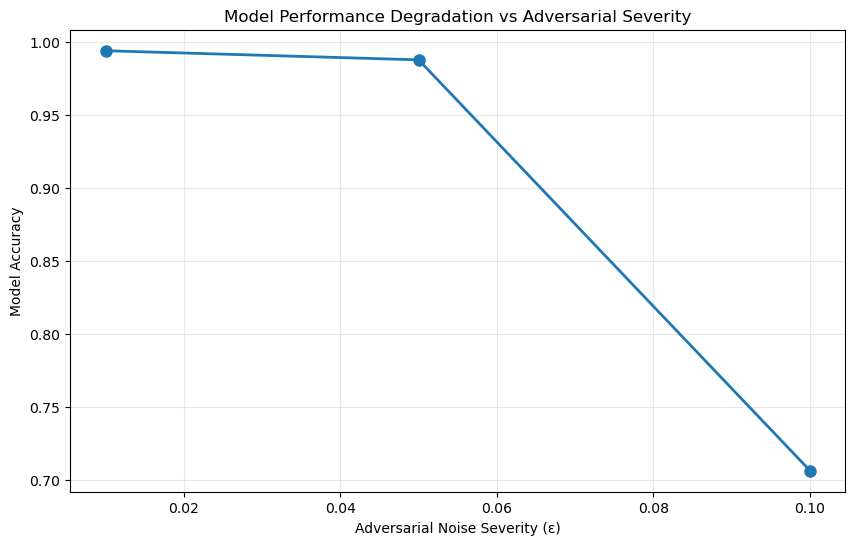

Epsilon 0.01: Accuracy = 99.38%
Epsilon 0.05: Accuracy = 98.75%
Epsilon 0.1: Accuracy = 70.62%


In [119]:
attack_results = evaluate_model_under_attack(siamese_model, test_data)

plot_severity_impact(attack_results)

for eps, accuracy in attack_results.items():
    print(f"Epsilon {eps}: Accuracy = {accuracy:.2%}")


In [112]:
def preprocess_twin_from_tensor(input_img, validation_img, label,
                                 apply_attack_angle=True,
                                 apply_adversarial_noise=True,
                                 apply_field_noise=False,
                                 epsilon=None):
    img1 = input_img
    img2 = validation_img

    if apply_attack_angle:
        img1 = add_attack_angle(img1)
        img2 = add_attack_angle(img2)

    if apply_adversarial_noise:
        img1 = add_adversarial_noise(img1, epsilon=epsilon)
        img2 = add_adversarial_noise(img2, epsilon=epsilon)

    if apply_field_noise:
        img1 = add_field_noise(img1)
        img2 = add_field_noise(img2)

    # ✅ Assert image shape before returning
    assert img1.shape == (100, 100, 3), f"img1 shape incorrect: {img1.shape}"
    assert img2.shape == (100, 100, 3), f"img2 shape incorrect: {img2.shape}"

    return (img1, img2, label)


In [113]:
import glob
from PIL import Image
import numpy as np
import tensorflow as tf

image_paths = glob.glob(f'{NEG_PATH}/*.jpg')  # Or .png if needed

def load_and_preprocess(path):
    img = Image.open(path).convert('RGB')
    img = img.resize((100, 100))  # Match Siamese input size
    img = np.array(img) / 255.0   # Normalize to [0, 1]
    
    if img.ndim == 2:  # Convert grayscale to RGB
        img = np.stack([img] * 3, axis=-1)
        
    return tf.convert_to_tensor(img, dtype=tf.float32)

ood_images = [load_and_preprocess(p) for p in image_paths[:20]]  # Use top 20 for now

for img1, img2, label in test_data.take(1):
    real_img = img1[0]  # Take first image
    real_img = tf.image.resize(real_img, [100, 100])  # Resize it manually
    break

ood_pairs = [(ood, real_img) for ood in ood_images]

processed_ood_pairs = [
    preprocess_twin_from_tensor(ood_img, real_img, label=0)
    for ood_img, real_img in ood_pairs
]


print("🔍 Checking model behavior on OOD + Real image pairs...\n")

for i, (img1, img2, _) in enumerate(processed_ood_pairs):
    img1_batch = tf.expand_dims(img1, axis=0)  
    img2_batch = tf.expand_dims(img2, axis=0)

    print(f"img1_batch.shape = {img1_batch.shape}, img2_batch.shape = {img2_batch.shape}")  # Debug

    prediction = siamese_model.predict([img1_batch, img2_batch], verbose=0)
    print(f"OOD Pair {i+1}: Similarity Score = {prediction[0][0]:.4f}")



🔍 Checking model behavior on OOD + Real image pairs...

img1_batch.shape = (1, 100, 100, 3), img2_batch.shape = (1, 100, 100, 3)
OOD Pair 1: Similarity Score = 0.0000
img1_batch.shape = (1, 100, 100, 3), img2_batch.shape = (1, 100, 100, 3)
OOD Pair 2: Similarity Score = 0.0000
img1_batch.shape = (1, 100, 100, 3), img2_batch.shape = (1, 100, 100, 3)
OOD Pair 3: Similarity Score = 0.0000
img1_batch.shape = (1, 100, 100, 3), img2_batch.shape = (1, 100, 100, 3)
OOD Pair 4: Similarity Score = 0.0047
img1_batch.shape = (1, 100, 100, 3), img2_batch.shape = (1, 100, 100, 3)
OOD Pair 5: Similarity Score = 0.0001
img1_batch.shape = (1, 100, 100, 3), img2_batch.shape = (1, 100, 100, 3)
OOD Pair 6: Similarity Score = 0.0000
img1_batch.shape = (1, 100, 100, 3), img2_batch.shape = (1, 100, 100, 3)
OOD Pair 7: Similarity Score = 0.0000
img1_batch.shape = (1, 100, 100, 3), img2_batch.shape = (1, 100, 100, 3)
OOD Pair 8: Similarity Score = 0.0001
img1_batch.shape = (1, 100, 100, 3), img2_batch.shape = 